In [ ]:
# Trevor Ahlberg, Sac State ID: 302002051, CSC 180 Intelligent Systems, Final Project, 11-28-21

# Load libraries and helper functions

In [18]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Install astroNN to download Galaxy10 DECals 

In [19]:
!pip install git+https://github.com/henrysky/astroNN.git

  Running command git clone -q https://github.com/henrysky/astroNN.git 'C:\Users\Counterbalance\AppData\Local\Temp\pip-req-build-nnm3yrgq'



  Cloning https://github.com/henrysky/astroNN.git to c:\users\counterbalance\appdata\local\temp\pip-req-build-nnm3yrgq


In [105]:
import tensorflow as tf

# Data Preprocessing

## Use the given astroNN functions to import Galaxy10 DECals Dataset (code block from astroNN)

In [21]:
from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils

# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10()

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

C:\Users\Counterbalance\.astroNN\datasets\Galaxy10_DECals.h5 was found!


In [22]:
from sklearn.model_selection import train_test_split

#Create train-test split
x_train, x_test, y_train, y_test = train_test_split(images,labels, test_size=0.25, random_state=42)

## Resize images from 256x256 to 128x128

In [25]:
import skimage.transform
from skimage.transform import resize

new_x_train = np.zeros((13302, 128, 128, 3))

for n,i in enumerate(x_train):
  new_x_train[n,:,:,:] = resize(x_train[n,:,:,:], (128, 128, 3))

In [26]:
new_x_test = np.zeros((4434, 128, 128, 3))

for n,i in enumerate(x_test):
  new_x_test[n,:,:,:] = resize(x_test[n,:,:,:], (128, 128, 3))
  

In [27]:
#Normalize images
new_x_train /= 255
new_x_test /= 255

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

num_classes = 10

# Control Model

In [104]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=new_x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

# print out the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_286 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
activation_288 (Activation)  (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_289 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)      

In [30]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Define compiler
model.compile(loss="categorical_crossentropy", optimizer="adam")

#Create callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(os.path.join(save_path,"best_cnn_weights.hdf5"), verbose=0, save_best_only=True) # save best model

#Fit data
model.fit(new_x_train, y_train, validation_data=(new_x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000)  
#model.load_weights(os.path.join(save_path,"best_cnn_weights.hdf5")) # load weights from best model









Epoch 1/1000
104/104 - 162s - loss: 2.2702 - val_loss: 2.0113
Epoch 2/1000
104/104 - 151s - loss: 1.9189 - val_loss: 1.8142
Epoch 3/1000
104/104 - 155s - loss: 1.7274 - val_loss: 1.6020
Epoch 4/1000
104/104 - 150s - loss: 1.5666 - val_loss: 1.4784
Epoch 5/1000
104/104 - 150s - loss: 1.4149 - val_loss: 1.4257
Epoch 6/1000
104/104 - 147s - loss: 1.3175 - val_loss: 1.3553
Epoch 7/1000
104/104 - 150s - loss: 1.1993 - val_loss: 1.3584
Epoch 8/1000
104/104 - 149s - loss: 1.1204 - val_loss: 1.3580
Epoch 9/1000
104/104 - 146s - loss: 1.0165 - val_loss: 1.3584
Epoch 10/1000
104/104 - 155s - loss: 0.9196 - val_loss: 1.4390
Epoch 11/1000
104/104 - 153s - loss: 0.8342 - val_loss: 1.4970
Epoch 00011: early stopping


In [97]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test,axis=1)
pred = model.predict(new_x_test)
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))




Accuracy: 0.5083446098331078
Averaged F1: 0.4962347738326163
              precision    recall  f1-score   support

           0       0.34      0.14      0.20       263
           1       0.59      0.44      0.50       462
           2       0.55      0.71      0.62       657
           3       0.49      0.50      0.50       487
           4       0.54      0.15      0.24        92
           5       0.43      0.36      0.39       543
           6       0.38      0.40      0.39       442
           7       0.42      0.47      0.44       668
           8       0.72      0.78      0.75       362
           9       0.59      0.70      0.64       458

    accuracy                           0.51      4434
   macro avg       0.50      0.47      0.47      4434
weighted avg       0.50      0.51      0.50      4434



Image 0
Predicted: in-between round smooth
Actual: in-between round smooth


Image 1
Predicted: merging
Actual: edge-on with bulge


Image 2
Predicted: barred spiral
Actual: unbarred tight spiral


Image 3
Predicted: round smooth
Actual: in-between round smooth


Image 4
Predicted: round smooth
Actual: round smooth




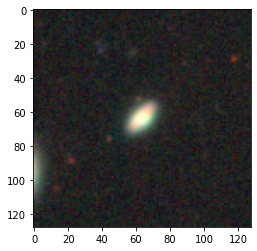

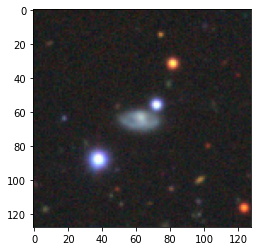

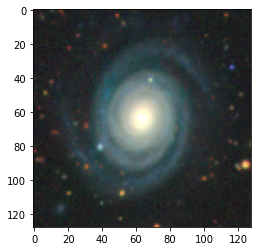

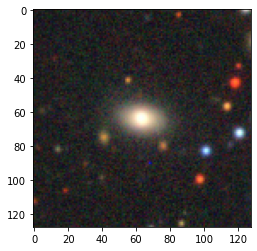

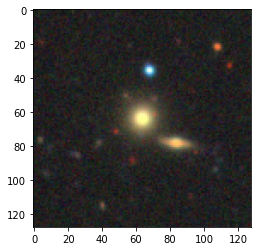

In [35]:
from random import seed
from random import randint


df = pd.DataFrame(y_test, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

df = df.idxmax(axis=1);



seed()
rand_arr = [randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1))]

test_image = list(range(5))
test_label = list(range(5))
for i in range(5):
    test_image[i] = new_x_test[rand_arr[i]]
    test_label[i] = df.iloc[rand_arr[i]]

sample_pred = model.predict(np.array(test_image, dtype=float))
pred_df = pd.DataFrame(sample_pred, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

pred_df = pred_df.idxmax(axis=1);

# print out prediction

for i in range(5):
  plt.figure()
  plt.imshow(test_image[i])
  print("Image " + str(i))
  print("Predicted: " + pred_df.iloc[i])
  print("Actual: " + test_label[i])
  print("\n")

# MobileNet Model

In [49]:
#Load MobileNet model
mobilenet_model = tf.keras.applications.MobileNet(input_shape=(128, 128, 3), weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 0s 0us/step


In [50]:
#Build sequential model for MobileNet
mn_model = Sequential()

for layer in mobilenet_model.layers:
  mn_model.add(layer)


# print out the model summary
mn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)       

In [51]:
for layer in mn_model.layers:
  layer.trainable = False



In [52]:
mn_model.add(Flatten())

mn_model.add(Dense(10, activation= 'softmax'))


In [54]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Define compiler
mn_model.compile(loss="categorical_crossentropy", optimizer="adam")

#Create callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(os.path.join(save_path,"best_cnn_weights.hdf5"), verbose=0, save_best_only=True) # save best model

#Fit data
mn_model.fit(new_x_train, y_train, validation_data=(new_x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000)  
#model.load_weights(os.path.join(save_path,"best_cnn_weights.hdf5")) # load weights from best model




Epoch 1/1000
104/104 - 84s - loss: 1.7560 - val_loss: 1.3517
Epoch 2/1000
104/104 - 83s - loss: 0.9511 - val_loss: 1.2631
Epoch 3/1000
104/104 - 83s - loss: 0.7240 - val_loss: 1.3096
Epoch 4/1000
104/104 - 87s - loss: 0.5923 - val_loss: 1.3226
Epoch 5/1000
104/104 - 83s - loss: 0.4634 - val_loss: 1.3736
Epoch 6/1000
104/104 - 82s - loss: 0.3923 - val_loss: 1.3173
Epoch 7/1000
104/104 - 82s - loss: 0.3090 - val_loss: 1.3575
Epoch 00007: early stopping


In [94]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test,axis=1)
pred = mn_model.predict(new_x_test)
pred = np.argmax(pred,axis=1)


mn_score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(mn_score))


mn_f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(mn_f1))

           
print(metrics.classification_report(y_true, pred))




Accuracy: 0.6132160577356789
Averaged F1: 0.604732856205331
              precision    recall  f1-score   support

           0       0.26      0.16      0.20       263
           1       0.72      0.52      0.60       462
           2       0.71      0.81      0.75       657
           3       0.63      0.68      0.65       487
           4       0.67      0.28      0.40        92
           5       0.70      0.36      0.47       543
           6       0.46      0.66      0.54       442
           7       0.45      0.57      0.50       668
           8       0.84      0.82      0.83       362
           9       0.78      0.84      0.81       458

    accuracy                           0.61      4434
   macro avg       0.62      0.57      0.58      4434
weighted avg       0.63      0.61      0.60      4434



Image 0
Predicted: unbarred loose spiral
Actual: disturbed


Image 1
Predicted: round smooth
Actual: in-between round smooth


Image 2
Predicted: edge-on with bulge
Actual: edge-on with bulge


Image 3
Predicted: edge-on with bulge
Actual: edge-on with bulge


Image 4
Predicted: round smooth
Actual: round smooth




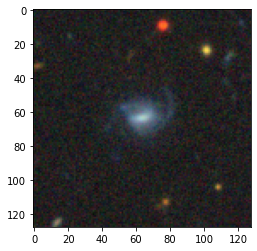

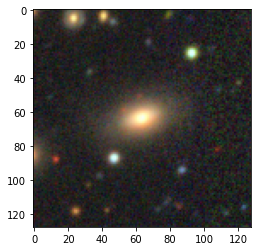

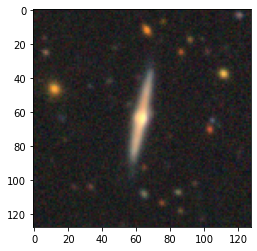

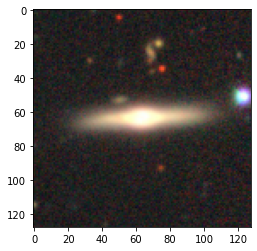

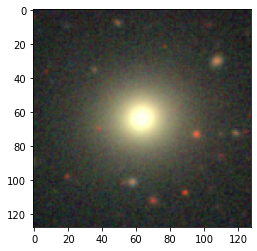

In [56]:
from random import seed
from random import randint


df = pd.DataFrame(y_test, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

df = df.idxmax(axis=1);



seed()
rand_arr = [randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1))]

test_image = list(range(5))
test_label = list(range(5))
for i in range(5):
    test_image[i] = new_x_test[rand_arr[i]]
    test_label[i] = df.iloc[rand_arr[i]]

sample_pred = model.predict(np.array(test_image, dtype=float))
pred_df = pd.DataFrame(sample_pred, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

pred_df = pred_df.idxmax(axis=1);

# print out prediction

for i in range(5):
  plt.figure()
  plt.imshow(test_image[i])
  print("Image " + str(i))
  print("Predicted: " + pred_df.iloc[i])
  print("Actual: " + test_label[i])
  print("\n")

# ResNet50 Model

In [78]:
#Load ResNet50 Model
input_t = tf.keras.Input(shape=(128,128,3))
resnet50_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_t)

In [80]:
for layer in resnet50_model.layers:
  layer.trainable = False


In [81]:
#Create sequential model with ResNet50
rn50_model = Sequential()

rn50_model.add(resnet50_model)

rn50_model.add(Flatten())

rn50_model.add(Dense(10, activation= 'softmax'))

# print out the model summary
rn50_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                327690    
Total params: 23,915,402
Trainable params: 327,690
Non-trainable params: 23,587,712
_________________________________________________________________


In [82]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Define compiler
rn50_model.compile(loss="categorical_crossentropy", optimizer="adam")

#Create callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(os.path.join(save_path,"best_cnn_weights.hdf5"), verbose=0, save_best_only=True) # save best model

#Fit data
rn50_model.fit(new_x_train, y_train, validation_data=(new_x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000)  
#model.load_weights(os.path.join(save_path,"best_cnn_weights.hdf5")) # load weights from best model



Epoch 1/1000
104/104 - 256s - loss: 2.2186 - val_loss: 2.2076
Epoch 2/1000
104/104 - 256s - loss: 2.1342 - val_loss: 2.1175
Epoch 3/1000
104/104 - 247s - loss: 2.0742 - val_loss: 2.0558
Epoch 4/1000
104/104 - 250s - loss: 2.0339 - val_loss: 2.0201
Epoch 5/1000
104/104 - 251s - loss: 1.9952 - val_loss: 1.9657
Epoch 6/1000
104/104 - 243s - loss: 1.9783 - val_loss: 1.9922
Epoch 7/1000
104/104 - 232s - loss: 1.9616 - val_loss: 1.9388
Epoch 8/1000
104/104 - 230s - loss: 1.9343 - val_loss: 1.9265
Epoch 9/1000
104/104 - 235s - loss: 1.9190 - val_loss: 1.9404
Epoch 10/1000
104/104 - 230s - loss: 1.9059 - val_loss: 1.9064
Epoch 11/1000
104/104 - 229s - loss: 1.8890 - val_loss: 1.8760
Epoch 12/1000
104/104 - 233s - loss: 1.8962 - val_loss: 1.9177
Epoch 13/1000
104/104 - 230s - loss: 1.8827 - val_loss: 1.8803
Epoch 14/1000
104/104 - 234s - loss: 1.8675 - val_loss: 1.9084
Epoch 15/1000
104/104 - 231s - loss: 1.8517 - val_loss: 1.8932
Epoch 16/1000
104/104 - 230s - loss: 1.8440 - val_loss: 1.8452
E

In [95]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test,axis=1)
pred = rn50_model.predict(new_x_test)
pred = np.argmax(pred,axis=1)


rn50_score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(rn50_score))


rn50_f1 = metrics.f1_score(y_true, pred, average='weighted', labels=np.unique(pred))
print('Averaged F1: {}'.format(rn50_f1))

           
print(metrics.classification_report(y_true, pred))




Accuracy: 0.33716734325665315
Averaged F1: 0.3238412335374894
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.28      0.28      0.28       462
           2       0.32      0.61      0.42       657
           3       0.41      0.43      0.42       487
           4       0.00      0.00      0.00        92
           5       0.41      0.13      0.19       543
           6       0.50      0.12      0.20       442
           7       0.27      0.56      0.36       668
           8       0.80      0.21      0.33       362
           9       0.42      0.39      0.41       458

    accuracy                           0.34      4434
   macro avg       0.34      0.27      0.26      4434
weighted avg       0.37      0.34      0.30      4434



C:\Users\Counterbalance\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Counterbalance\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\Counterbalance\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image 0
Predicted: edge-on without bulge
Actual: edge-on without bulge


Image 1
Predicted: unbarred loose spiral
Actual: unbarred tight spiral


Image 2
Predicted: unbarred loose spiral
Actual: barred spiral


Image 3
Predicted: in-between round smooth
Actual: in-between round smooth


Image 4
Predicted: edge-on without bulge
Actual: edge-on without bulge




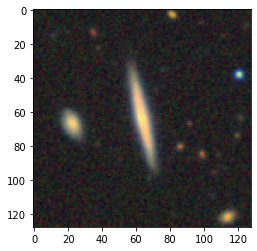

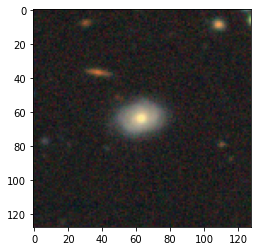

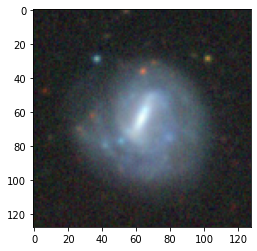

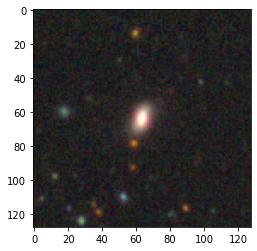

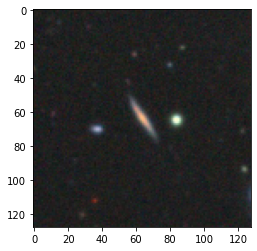

In [85]:
from random import seed
from random import randint


df = pd.DataFrame(y_test, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

df = df.idxmax(axis=1);



seed()
rand_arr = [randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1))]

test_image = list(range(5))
test_label = list(range(5))
for i in range(5):
    test_image[i] = new_x_test[rand_arr[i]]
    test_label[i] = df.iloc[rand_arr[i]]

sample_pred = model.predict(np.array(test_image, dtype=float))
pred_df = pd.DataFrame(sample_pred, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

pred_df = pred_df.idxmax(axis=1);

# print out prediction

for i in range(5):
  plt.figure()
  plt.imshow(test_image[i])
  print("Image " + str(i))
  print("Predicted: " + pred_df.iloc[i])
  print("Actual: " + test_label[i])
  print("\n")

# Inception-v3 Model

In [86]:
#Import Inception-v3 model
input_t = tf.keras.Input(shape=(128,128,3))
inceptionv3_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=input_t)

In [87]:
for layer in inceptionv3_model.layers:
  layer.trainable = False


In [88]:
#Create sequential model using Inception-v3
iv3_model = Sequential()

iv3_model.add(resnet50_model)

iv3_model.add(Flatten())

iv3_model.add(Dense(10, activation= 'softmax'))

# print out the model summary
iv3_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                327690    
Total params: 23,915,402
Trainable params: 327,690
Non-trainable params: 23,587,712
_________________________________________________________________


In [89]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Define compiler
iv3_model.compile(loss="categorical_crossentropy", optimizer="adam")

#Create callbacks
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(os.path.join(save_path,"best_cnn_weights.hdf5"), verbose=0, save_best_only=True) # save best model

#Fit data
iv3_model.fit(new_x_train, y_train, validation_data=(new_x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000)  
#model.load_weights(os.path.join(save_path,"best_cnn_weights.hdf5")) # load weights from best model



Epoch 1/1000
104/104 - 234s - loss: 2.2220 - val_loss: 2.2272
Epoch 2/1000
104/104 - 232s - loss: 2.1392 - val_loss: 2.1132
Epoch 3/1000
104/104 - 235s - loss: 2.0691 - val_loss: 2.0963
Epoch 4/1000
104/104 - 238s - loss: 2.0293 - val_loss: 2.0820
Epoch 5/1000
104/104 - 231s - loss: 2.0018 - val_loss: 1.9783
Epoch 6/1000
104/104 - 229s - loss: 1.9825 - val_loss: 1.9686
Epoch 7/1000
104/104 - 232s - loss: 1.9465 - val_loss: 1.9635
Epoch 8/1000
104/104 - 238s - loss: 1.9350 - val_loss: 1.9518
Epoch 9/1000
104/104 - 237s - loss: 1.9166 - val_loss: 1.9723
Epoch 10/1000
104/104 - 227s - loss: 1.9139 - val_loss: 1.8849
Epoch 11/1000
104/104 - 228s - loss: 1.8904 - val_loss: 1.9224
Epoch 12/1000
104/104 - 229s - loss: 1.8848 - val_loss: 1.9582
Epoch 13/1000
104/104 - 234s - loss: 1.8812 - val_loss: 1.8897
Epoch 14/1000
104/104 - 241s - loss: 1.8688 - val_loss: 1.8439
Epoch 15/1000
104/104 - 224s - loss: 1.8544 - val_loss: 1.8509
Epoch 16/1000
104/104 - 226s - loss: 1.8527 - val_loss: 1.9356
E

In [96]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test,axis=1)
pred = iv3_model.predict(new_x_test)
pred = np.argmax(pred,axis=1)


iv3_score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(iv3_score))


iv3_f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(iv3_f1))

           
print(metrics.classification_report(y_true, pred))




Accuracy: 0.3522778529544429
Averaged F1: 0.3409701071840875
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.23      0.55      0.32       462
           2       0.38      0.48      0.43       657
           3       0.60      0.31      0.41       487
           4       1.00      0.01      0.02        92
           5       0.30      0.37      0.33       543
           6       0.45      0.19      0.27       442
           7       0.30      0.33      0.32       668
           8       0.77      0.31      0.44       362
           9       0.44      0.48      0.46       458

    accuracy                           0.35      4434
   macro avg       0.45      0.30      0.30      4434
weighted avg       0.40      0.35      0.34      4434



Image 0
Predicted: unbarred loose spiral
Actual: unbarred loose spiral


Image 1
Predicted: round smooth
Actual: unbarred loose spiral


Image 2
Predicted: unbarred loose spiral
Actual: unbarred loose spiral


Image 3
Predicted: barred spiral
Actual: barred spiral


Image 4
Predicted: edge-on with bulge
Actual: edge-on without bulge




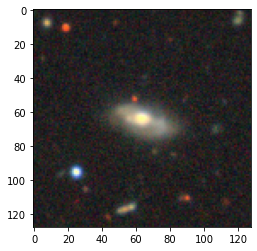

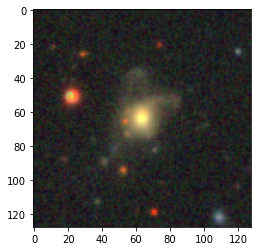

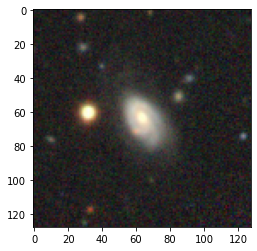

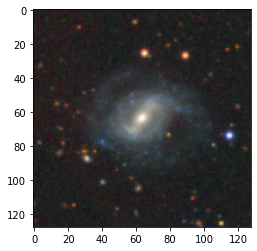

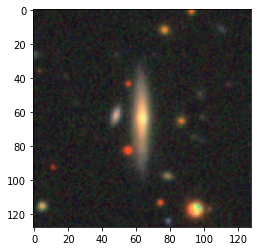

In [91]:
from random import seed
from random import randint


df = pd.DataFrame(y_test, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

df = df.idxmax(axis=1);



seed()
rand_arr = [randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1)), 
            randint(0, (new_x_test.shape[0]-1))]

test_image = list(range(5))
test_label = list(range(5))
for i in range(5):
    test_image[i] = new_x_test[rand_arr[i]]
    test_label[i] = df.iloc[rand_arr[i]]

sample_pred = model.predict(np.array(test_image, dtype=float))
pred_df = pd.DataFrame(sample_pred, columns = [
    'disturbed',
    'merging',
    'round smooth',
    'in-between round smooth',
    'cigar shaped',
    'barred spiral',
    'unbarred tight spiral',
    'unbarred loose spiral',
    'edge-on without bulge',
    'edge-on with bulge'
] )

pred_df = pred_df.idxmax(axis=1);

# print out prediction

for i in range(5):
  plt.figure()
  plt.imshow(test_image[i])
  print("Image " + str(i))
  print("Predicted: " + pred_df.iloc[i])
  print("Actual: " + test_label[i])
  print("\n")

# Results Summary 

## Accuracy scores

Accuracy scores


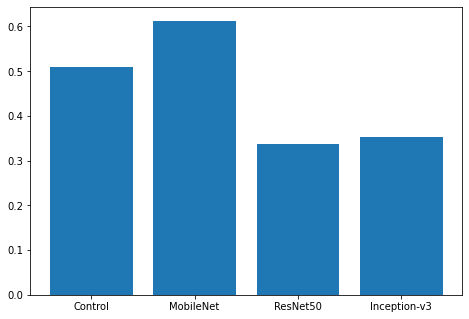

In [102]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Control', 'MobileNet', 'ResNet50', 'Inception-v3']
students = [score, mn_score, rn50_score, iv3_score]
ax.bar(langs,students)
print("Accuracy scores")
plt.show()

## F1 scores

F1 scores


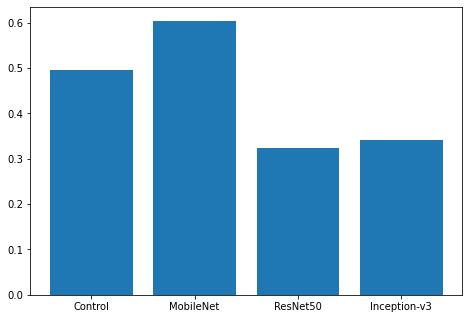

In [103]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Control', 'MobileNet', 'ResNet50', 'Inception-v3']
students = [f1, mn_f1, rn50_f1, iv3_f1]
ax.bar(langs,students)
print("F1 scores")
plt.show()